In [1]:
import config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math

In [2]:
sns.set(style='whitegrid')
engine = config.engine

In [3]:
qry = 'SELECT * FROM train_data'
    

In [84]:
data = pd.read_sql(sql=qry, con=engine)

In [85]:
for x in data.columns:
    print(x)

tui
transaction_date
postcode
ptype
new_build
tenure
paon
saon
street
locality
city
rdistrict
county
category
status
address_match
lmk_key
address1
address2
address3
address4
building_reference_number
current_energy_rating
potential_energy_rating
current_energy_efficiency
potential_energy_efficiency
property_type
built_form
inspection_date
local_authority
constituency
lodgement_date
transaction_type
environment_impact_current
environment_impact_potential
energy_consumption_current
energy_consumption_potential
co2_emissions_current
co2_emiss_curr_per_floor_area
co2_emissions_potential
lighting_cost_current
lighting_cost_potential
heating_cost_current
heating_cost_potential
hot_water_cost_current
hot_water_cost_potential
total_floor_area
energy_tariff
mains_gas_flag
floor_level
flat_top_storey
flat_storey_count
main_heating_controls
multi_glaze_proportion
glazed_type
glazed_area
extension_count
number_habitable_rooms
number_heated_rooms
low_energy_lighting
number_open_fireplaces
hotwater

In [86]:
# Remove administrative columns and current energy rating/potential energy rating
data.drop(['tui',
          'paon',
          'saon',
          'street',
          'locality',
          'city',
          'address1',
          'address2',
          'address3',
          'address4',
          'address',
          'rdistrict',
          'county',
          'category',
          'status',
          'address_match',
          'lmk_key',
          'building_reference_number',
          'local_authority_label',
          'local_authority',
          'constituency',
          'constituency_label',
          'posttown',
          'lodgement_datetime',
          'lodgement_date',
          'inspection_date',
          'built_form',
          'current_energy_rating',
          'potential_energy_rating',
          'transaction_type',
          'lsoa_name',
          'local_authority_code',
          'local_authority_name'],
         axis=1,
         inplace=True)

In [87]:
data.groupby(['ptype', 'property_type'])['postcode'].count()

ptype  property_type
D      Bungalow          79
       Flat               1
       House            327
F      Bungalow           1
       Flat             396
       House             11
       Maisonette        36
S      Bungalow          21
       Flat               4
       House            606
       Maisonette         1
T      Bungalow           8
       Flat               5
       House            305
Name: postcode, dtype: int64

In [88]:
data['bungalow_flag'] = np.where(data['property_type'] == 'Bungalow', 1, 0)
data.drop('property_type', axis=1, inplace=True)

In [89]:
# Replace invalid values with nan
data.replace('', np.nan, inplace=True)
data.replace('N/A', np.nan, inplace=True)
data.replace('NO DATA!', np.nan, inplace=True)
data.replace('NODATA!', np.nan, inplace=True)
data.replace('-1', np.nan, inplace=True)
data.replace('INVALID!', np.nan, inplace=True)
data.replace('Unknown', np.nan, inplace=True)
data.replace('unknown', np.nan, inplace=True)
data.replace('not defined', np.nan, inplace=True)
data.fillna(np.nan, inplace=True)

In [90]:
#data.drop(data.columns[data.isnull().all()], axis=1, inplace=True)

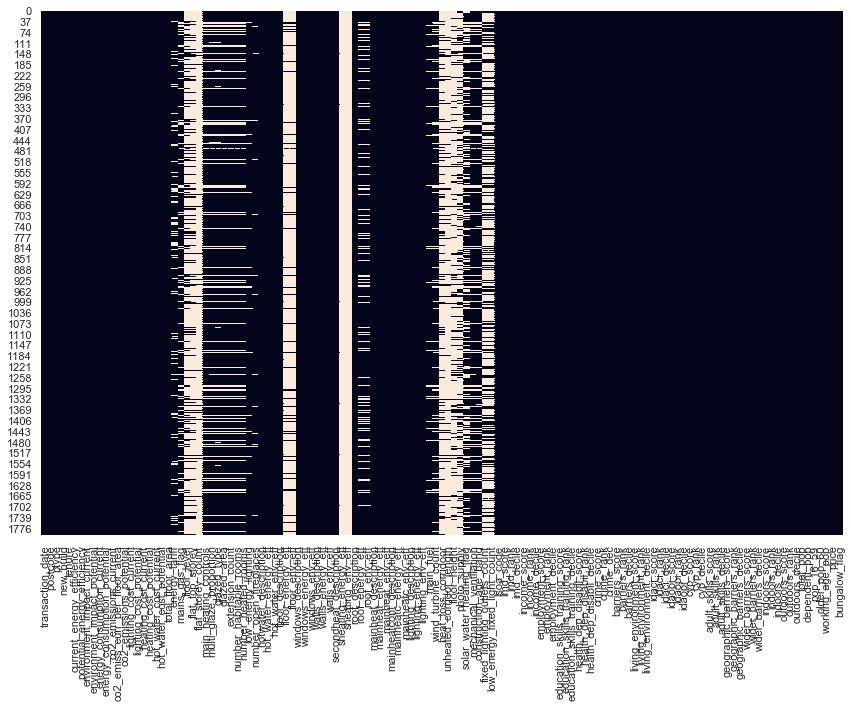

In [91]:
plt.figure(figsize=(12, 10))
sns.heatmap(data.isnull(), cbar=False, xticklabels=data.columns)
plt.tight_layout()
plt.show()

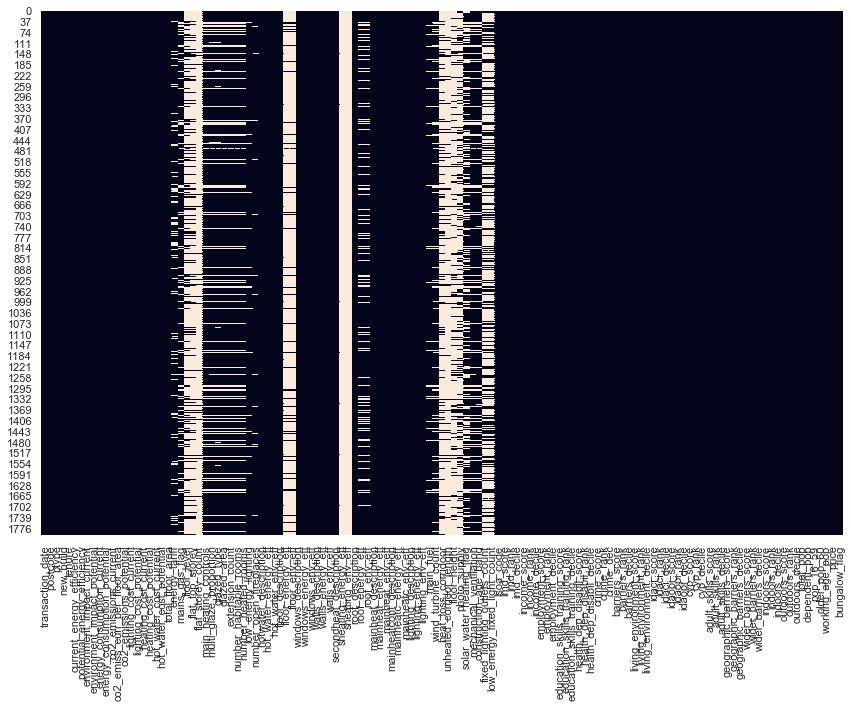

In [92]:
plt.figure(figsize=(12, 10))
sns.heatmap(data.isnull(), cbar=False, xticklabels=data.columns)
plt.tight_layout()
plt.savefig('figures/missing_data.png')
plt.show()

In [93]:
# remove columns with > 20% missing data
usable_cols = data.columns[data.isnull().mean() < 0.2]
data = data[usable_cols]

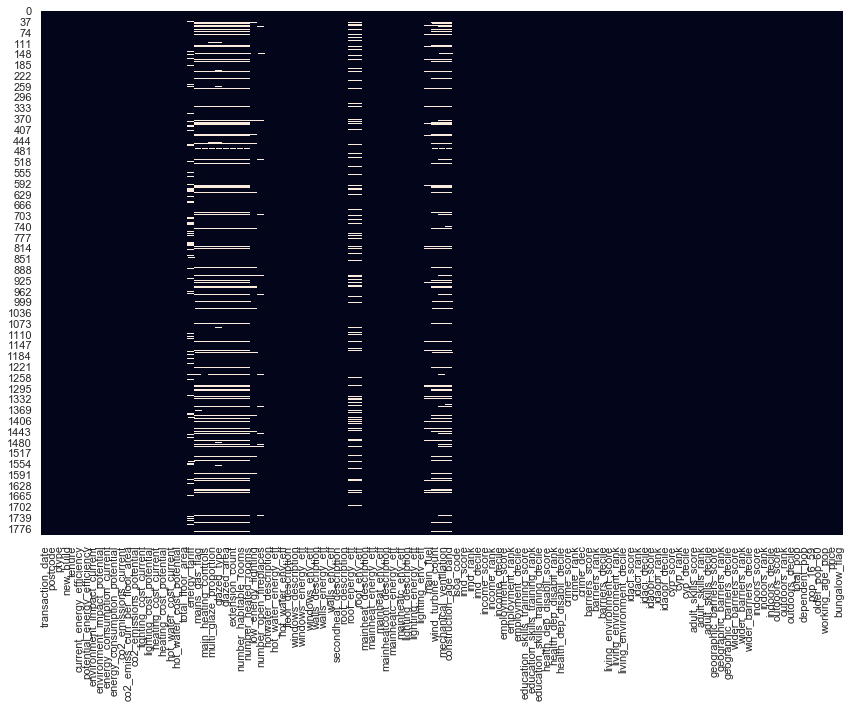

In [94]:
plt.figure(figsize=(12, 10))
sns.heatmap(data.isnull(), cbar=False, xticklabels=data.columns)
plt.tight_layout()
plt.show()

In [95]:
eff_cols = data.columns[(data == 'Poor').any()]
eff_cols

C:\Users\neils\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


Index(['hot_water_energy_eff', 'hot_water_env_eff', 'windows_energy_eff',
       'windows_env_eff', 'walls_energy_eff', 'walls_env_eff',
       'roof_energy_eff', 'roof_env_eff', 'mainheat_energy_eff',
       'mainheat_env_eff', 'mainheatc_energy_eff', 'mainheatc_env_eff',
       'lighting_energy_eff', 'lighting_env_eff'],
      dtype='object')

In [96]:
# Map good poor categories to ordinal values 0, 1, 2, 3, 4
eff_map = {'Very Poor': 0, 'Poor': 1, 'Average': 2, 'Good': 3, 'Very Good': 4}
[x for x in data.columns if 'eff' in x and 'efficiency' not in x]

for c in eff_cols:
    data[c] = data[c].map(eff_map)

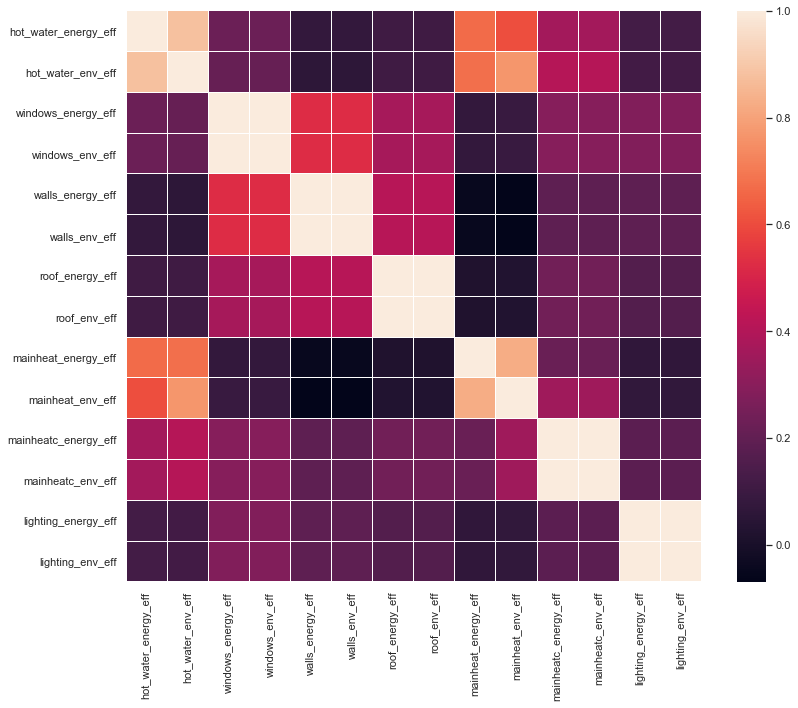

In [97]:
plt.figure(figsize=(12, 10))
sns.heatmap(data[eff_cols].corr(), xticklabels=eff_cols, linewidth=0.1, linecolor='w')
plt.tight_layout()
plt.savefig('figures/energy_env_eff_corr.png')
plt.show()

In [98]:
data.drop([x for x in eff_cols if 'env' in x], axis=1, inplace=True)

In [99]:
correl = data.select_dtypes(include=['int64', 'float64']).drop('price', axis=1).corr()

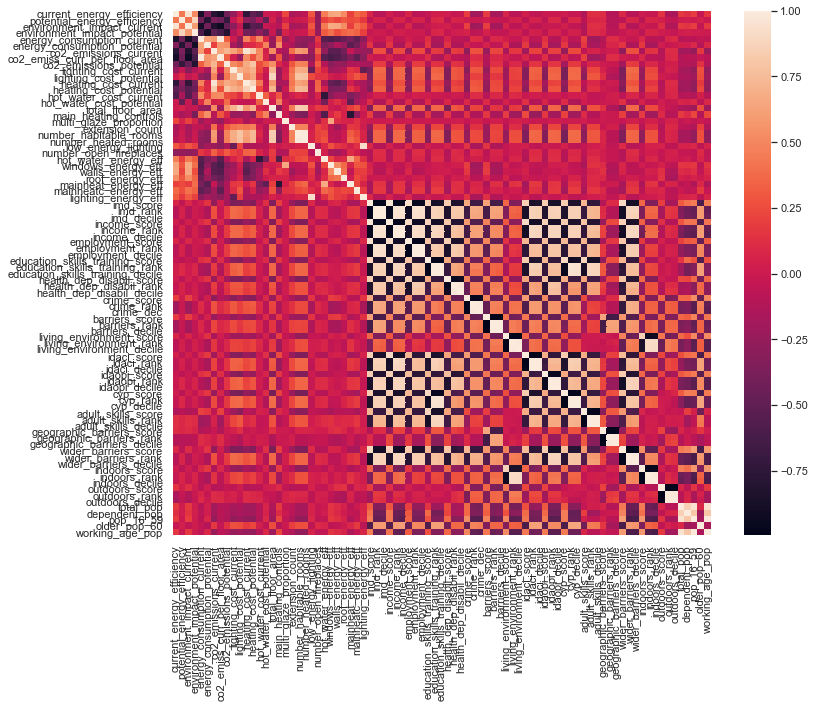

In [100]:
plt.figure(figsize=(12, 10))
sns.heatmap(correl, xticklabels=correl.columns, yticklabels=correl.columns)
plt.tight_layout()
plt.show()

<Figure size 720x432 with 0 Axes>

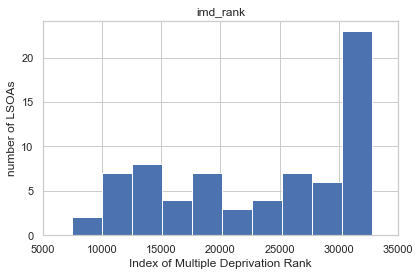

In [101]:
plt.figure(figsize=(10,6))
data[['lsoa_code', 'imd_rank']].drop_duplicates().hist()
plt.ylabel('number of LSOAs')
plt.xlabel('Index of Multiple Deprivation Rank')
plt.xlim(5000,35000)
plt.tight_layout()
plt.savefig('figures/imd_ranks.png')
plt.show()


In [102]:
data['imd_rank'].min(), data['imd_rank'].max()

(7496, 32834)

In [103]:
rank_dec_cols = [x for x in data.columns if '_rank' in x or '_dec' in x]
data.drop(rank_dec_cols, axis=1, inplace=True)

In [104]:
correl = data.select_dtypes(include=['int64', 'float64']).drop('price', axis=1).corr()

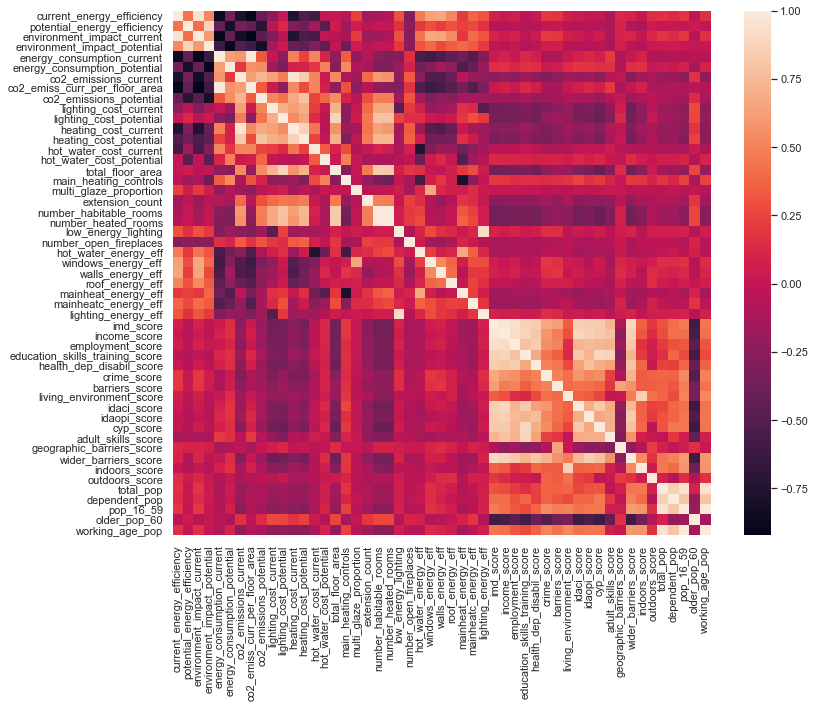

In [105]:
plt.figure(figsize=(12, 10))
sns.heatmap(correl, xticklabels=correl.columns, yticklabels=correl.columns)
plt.tight_layout()
plt.show()

In [106]:
print(data.select_dtypes(include=['object']).apply(lambda x: len(x.unique())).sort_values(ascending=False))

postcode                    998
transaction_date            439
lighting_description         93
lsoa_code                    71
roof_description             66
walls_description            52
floor_description            46
mainheatcont_description     23
mainheat_description         20
hotwater_description         13
construction_age_band        12
windows_description          12
secondheat_description       12
main_fuel                    11
glazed_area                   6
glazed_type                   6
energy_tariff                 6
ptype                         4
wind_turbine_count            3
mains_gas_flag                3
mechanical_ventilation        3
tenure                        2
new_build                     2
dtype: int64


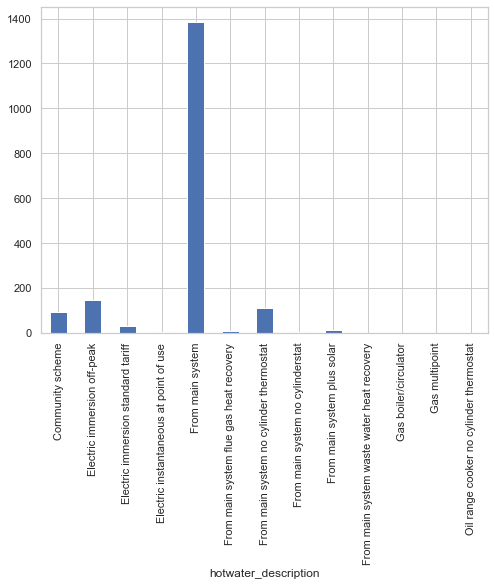

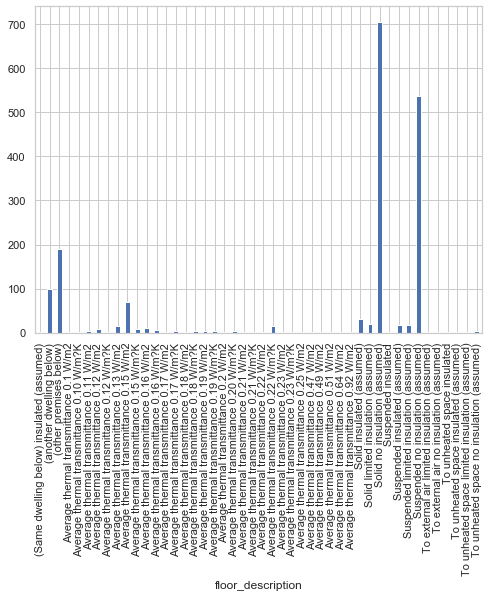

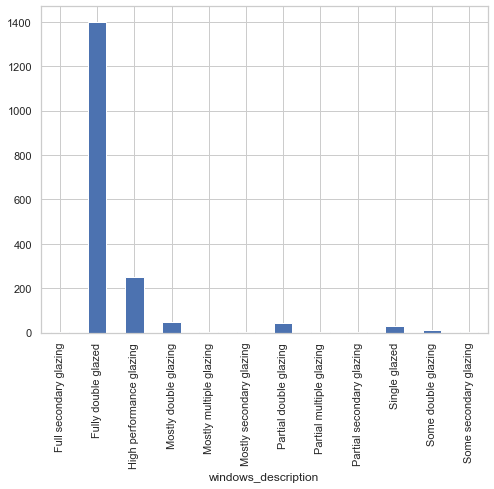

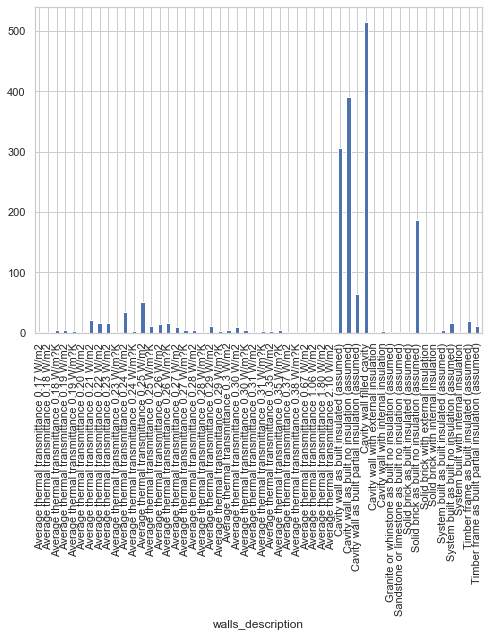

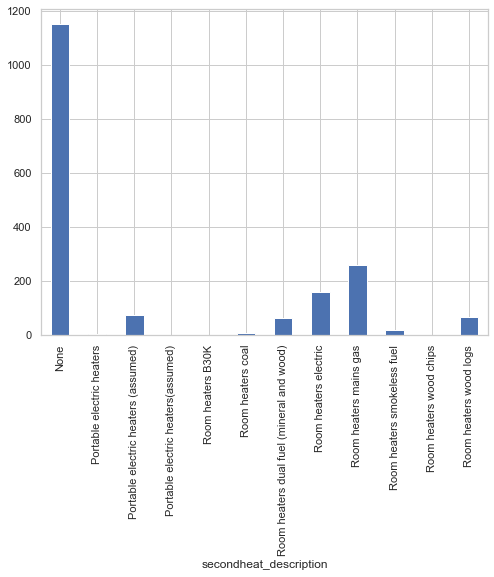

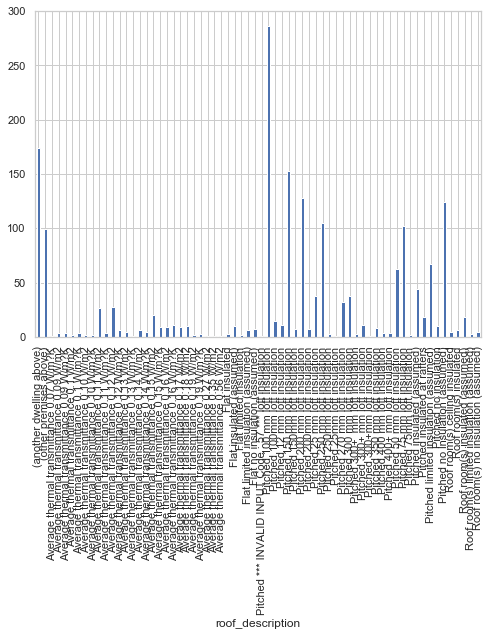

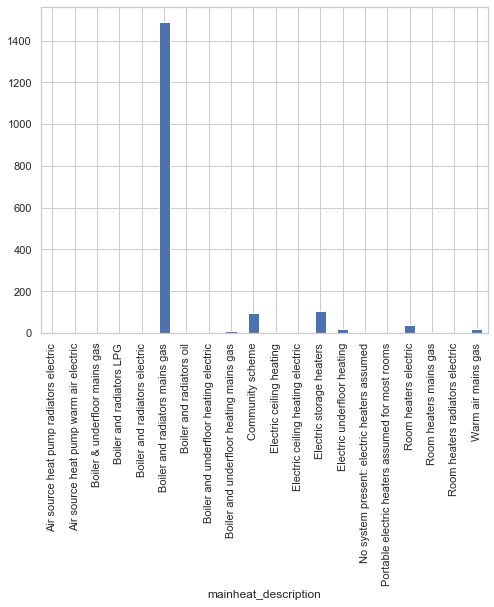

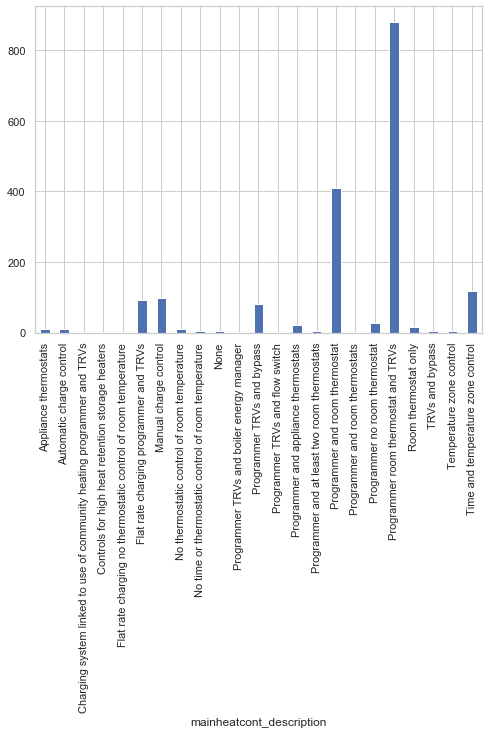

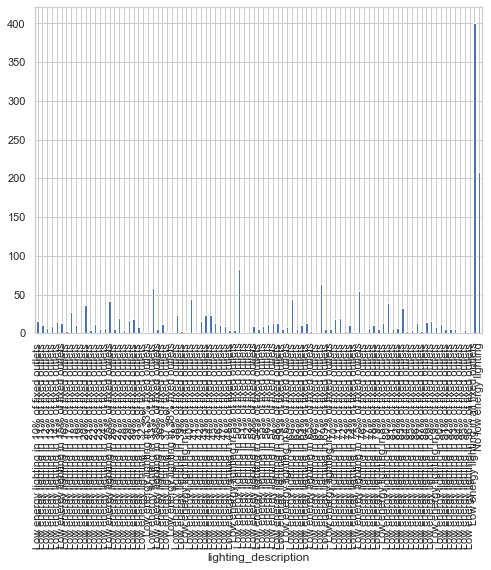

In [107]:
description_cols = [x for x in data.columns if 'description' in x]
for col in description_cols:
    plt.figure(figsize=(8,6))
    data.groupby(col)['price'].count().plot.bar()
    plt.show()

In [108]:
data['roof_description'].value_counts()

Pitched 100 mm loft insulation                             286
(another dwelling above)                                   174
Pitched 150 mm loft insulation                             153
Pitched 200 mm loft insulation                             128
Pitched no insulation (assumed)                            124
                                                          ... 
Average thermal transmittance 0.07 W/m?K                     1
Average thermal transmittance 0.13 W/m?K                     1
Pitched 25mm loft insulation                                 1
Pitched *** INVALID INPUT Code : 57 *** loft insulation      1
Pitched 300+mm loft insulation                               1
Name: roof_description, Length: 66, dtype: int64

In [109]:
data['windows_description'].value_counts()

Fully double glazed          1400
High performance glazing      251
Mostly double glazing          49
Partial double glazing         43
Single glazed                  31
Some double glazing            10
Full secondary glazing          4
Mostly secondary glazing        4
Partial secondary glazing       3
Mostly multiple glazing         2
Partial multiple glazing        2
Some secondary glazing          2
Name: windows_description, dtype: int64

In [110]:
data['mainheat_description'].value_counts()

Boiler and radiators mains gas                      1487
Electric storage heaters                             107
Community scheme                                      95
Room heaters electric                                 36
Electric underfloor heating                           19
Warm air mains gas                                    19
Boiler and underfloor heating mains gas                9
Boiler and radiators electric                          6
No system present: electric heaters assumed            4
Room heaters mains gas                                 3
Electric ceiling heating                               3
Boiler and radiators oil                               3
Boiler and radiators LPG                               2
Air source heat pump radiators electric                2
Electric ceiling heating electric                      1
Room heaters radiators electric                        1
Air source heat pump warm air electric                 1
Boiler & underfloor mains gas  

In [111]:
# Drop description columns with too many strings/categories that cannot be summarised
data.drop(description_cols, axis=1, inplace=True)

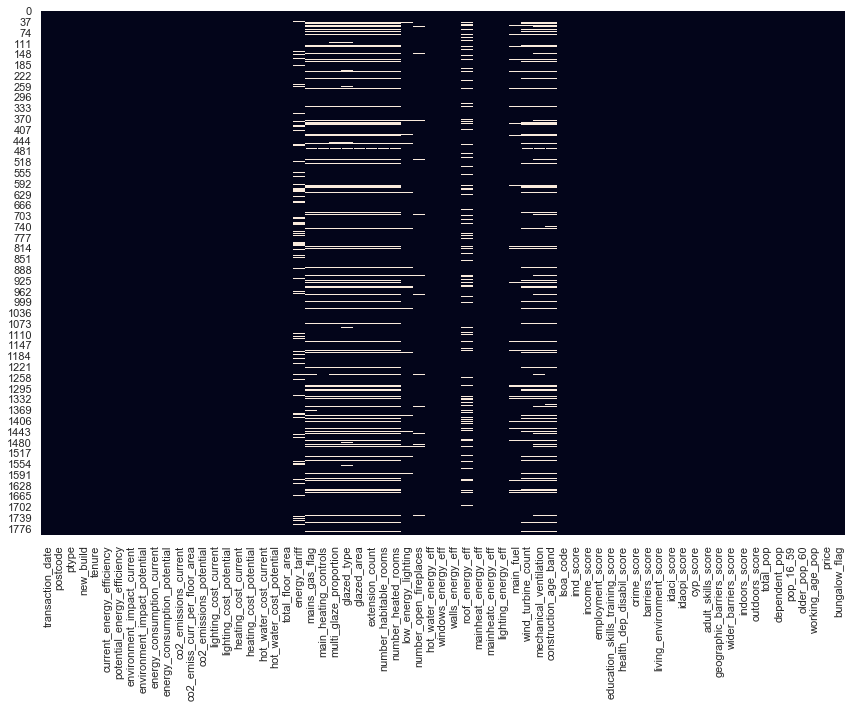

In [112]:
plt.figure(figsize=(12, 10))
sns.heatmap(data.isnull(), cbar=False, xticklabels=data.columns)
plt.tight_layout()
plt.show()

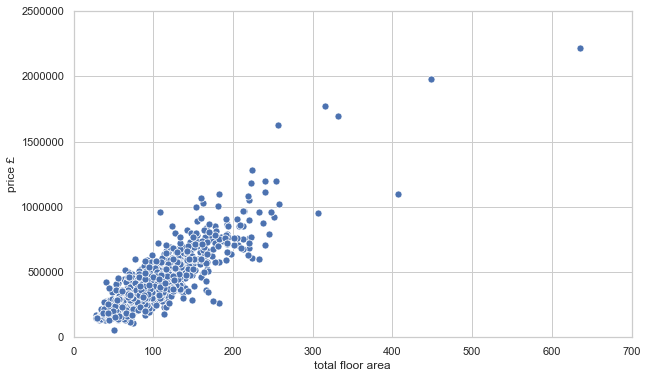

In [113]:
data['persqm'] = data['price'] / data['total_floor_area']
data['log_persqm'] = np.log(data['persqm'])
# Drop floor areas <= 10m2
data.drop(data[data['total_floor_area'] <= 10].index, inplace=True)
# Correct price entered in error
data.loc[data['price'] == 4920000, 'price'] = 492000

# Remove £/sqm outliers
desc = data['log_persqm'].describe()
mn = desc['mean']
sd = desc['std']

min_persqm = mn - sd * 7
max_persqm = mn + sd * 7

data['outlier'] = (data['log_persqm'] < min_persqm) | (data['log_persqm'] > max_persqm)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_floor_area', y='price', data=data, s=50)
plt.xlim(0, 700)
plt.ylim(0, 2500000)
plt.xlabel('total floor area')
plt.ylabel('price £')
plt.savefig('figures/price_floor_scatter.png')
plt.show()

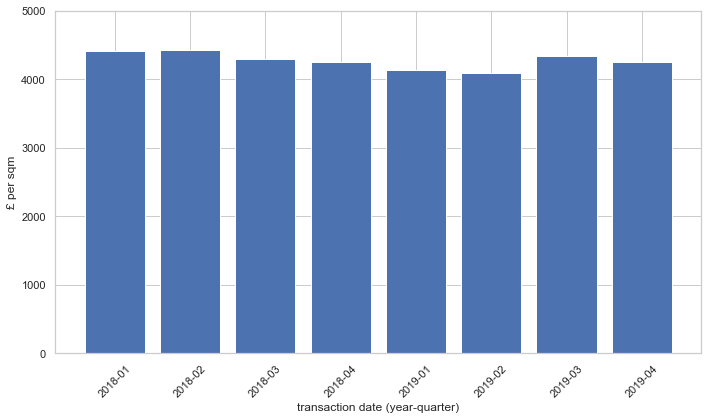

In [114]:
data['persqm'] = data['price'] / data['total_floor_area']

month_group = data.groupby(
    data['transaction_date'].apply(
        lambda x: '{}-{:02d}'.format(x.year, math.ceil(x.month / 3))
        )
    ).agg({'persqm': np.median, 'price': np.median}).reset_index()

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ln1 = ax.bar(month_group['transaction_date'], month_group['persqm'], color='b')
#sns.barplot(x='transaction_date', y='persqm', data=month_group, color='b')
for label in ax.get_xticklabels():
    label.set_rotation(45)
plt.ylim(0, 5000)
plt.ylabel('£ per sqm')
plt.xlabel('transaction date (year-quarter)')
plt.tight_layout()
plt.savefig('figures/median_price_per_sqm_time.png')
plt.show()

In [115]:
object_cols = data.select_dtypes(include='object').columns

for c in object_cols:
    print(data[c].value_counts())

2018-12-19    17
2018-06-29    17
2019-11-29    17
2019-12-20    17
2018-09-28    16
              ..
2018-12-03     1
2019-04-17     1
2018-01-30     1
2018-03-08     1
2018-04-12     1
Name: transaction_date, Length: 439, dtype: int64
HP13 5GA    21
HP13 5GH    18
HP13 5GB    16
HP13 5GD    15
HP13 7YG    13
            ..
HP15 6BE     1
HP12 4AB     1
HP13 6EZ     1
HP13 7TR     1
HP13 5JQ     1
Name: postcode, Length: 997, dtype: int64
S    632
F    439
D    407
T    318
Name: ptype, dtype: int64
N    1638
Y     158
Name: new_build, dtype: int64
F    1343
L     453
Name: tenure, dtype: int64
Single             1194
standard tariff     270
dual                146
dual (24 hour)        2
off-peak 7 hour       1
Name: energy_tariff, dtype: int64
Y    1356
N     164
Name: mains_gas_flag, dtype: int64
double glazing unknown install date              577
double glazing installed during or after 2002    468
double glazing installed before 2002             428
secondary glazing            

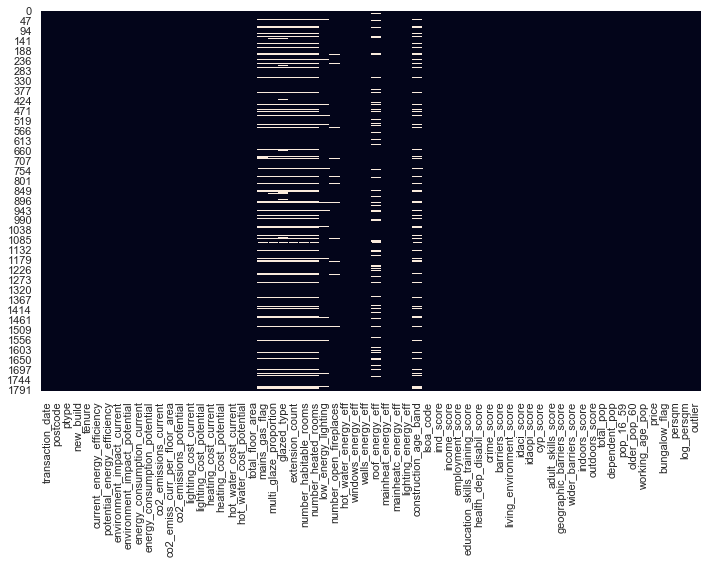

<Figure size 432x288 with 0 Axes>

In [116]:
# Drop columns with little variation or too many categories
data.drop(['wind_turbine_count', 'mechanical_ventilation',
                  'main_fuel', 'glazed_area', 'energy_tariff',
                  'main_heating_controls'],
                 axis=1,
                 inplace=True)

plt.figure(figsize=(10, 8))
sns.heatmap(data.isnull(), cbar=False, xticklabels=data.columns)
plt.tight_layout()
plt.show()
plt.savefig('figures/missing_data_2.png')

data.reset_index(drop=True, inplace=True)

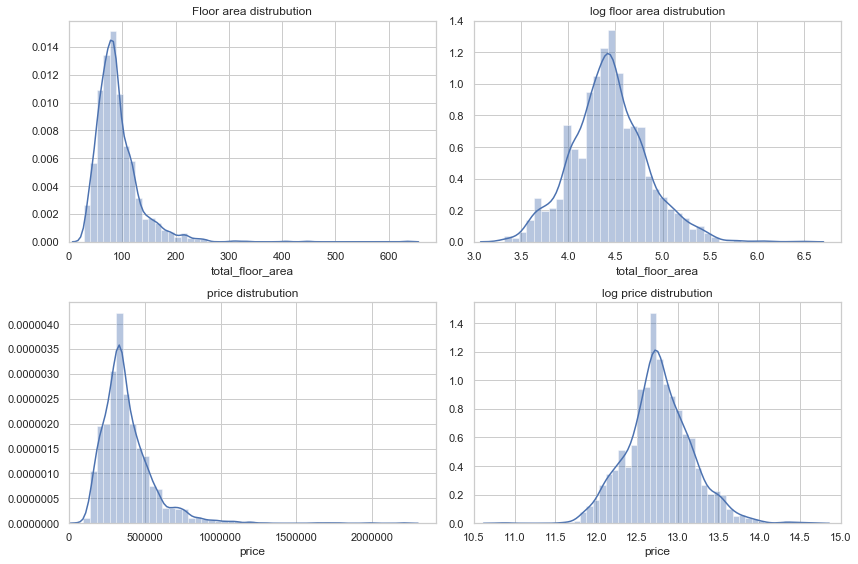

In [117]:
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.title('Floor area distrubution')
sns.distplot(data['total_floor_area'])
plt.xlim(0)
plt.subplot(222)
sns.distplot(np.log(data['total_floor_area']))
plt.title('log floor area distrubution')
plt.xlim(3)
plt.ylim(0, 1.4)
plt.subplot(223)
sns.distplot(data['price'])
plt.title('price distrubution')
plt.xlim(0)
plt.subplot(224)
sns.distplot(np.log(data['price']))
plt.title('log price distrubution')
plt.xlim(10.5, 15)
plt.tight_layout()
plt.savefig('figures/floor_price_distributions.png')
plt.show()

In [118]:
# data.to_sql('train_cleaned', con=engine, index=False, chunksize=5000, if_exists='replace')

In [119]:
data.drop(['log_persqm', 'outlier'], axis=1, inplace=True)

In [120]:
def geomean(x):
    return np.exp(np.mean(np.log(x)))

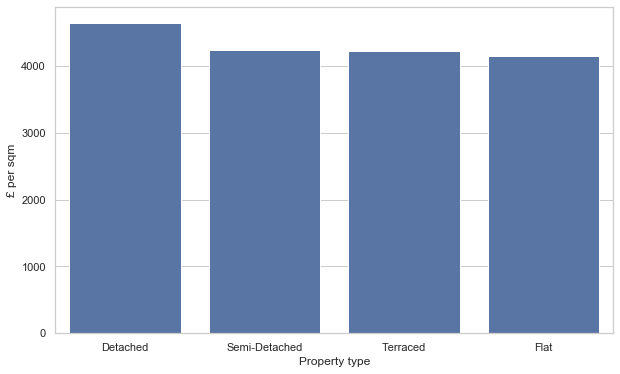

In [121]:
ptypes = data.groupby('ptype').agg({'persqm': 'mean'}).sort_values('persqm', ascending=False).reset_index()
plt.figure(figsize=(10,6))
ax = sns.barplot(x='ptype', y='persqm', data=ptypes, color='b')
ax.set_xticklabels(['Detached', 'Semi-Detached', 'Terraced', 'Flat'])
plt.xlabel('Property type')
plt.ylabel('£ per sqm')
plt.savefig('figures/persqm_by_type.png')

Text(0.5, 1.0, 'Price by type')

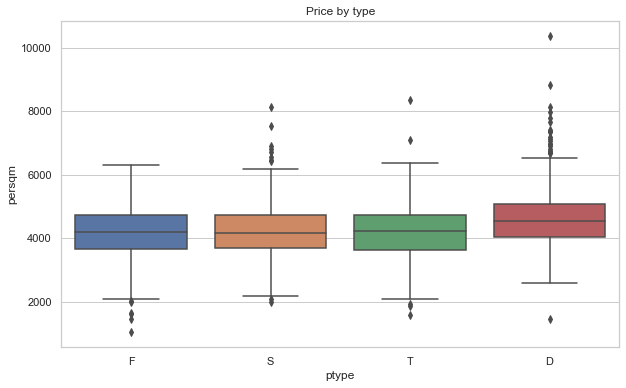

In [122]:
plt.figure(figsize=(10,6))
sns.boxplot(x='ptype', y='persqm', data=data)
plt.title('Price by type')

<Figure size 864x720 with 0 Axes>

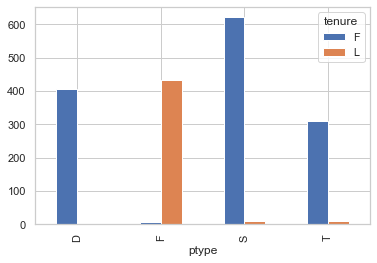

In [123]:
plt.figure(figsize=(12, 10))
data.pivot_table(index='ptype', values='price', columns='tenure', aggfunc='count').plot(kind='bar')
plt.show()

In [124]:
data.drop('tenure', axis=1, inplace=True)

In [125]:
def reg_plot(var, ln=False):
    vals = data[var].unique()

    plt.figure(figsize=(12,7))
    for v in vals:
        df = data[data[var] == v]
        if ln:
            dfvar = df['total_floor_area'].apply(np.log)
            p = df['price'].apply(np.log)
        else:
            dfvar = df['total_floor_area']
            p = df['price']
        sns.regplot(dfvar, p)


    plt.legend(list(vals))
    plt.title(f'Floor area and price by {var}')
    plt.show()

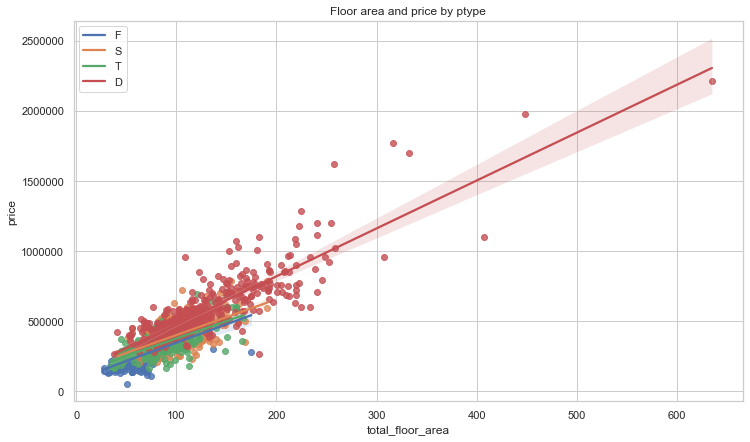

In [126]:
reg_plot('ptype')

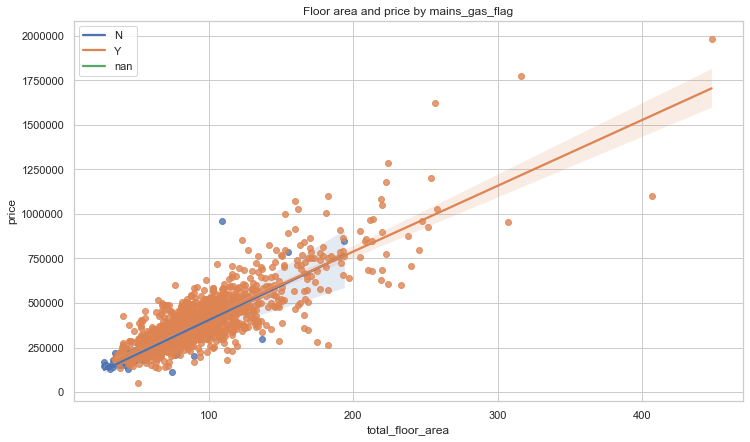

In [127]:
reg_plot('mains_gas_flag')

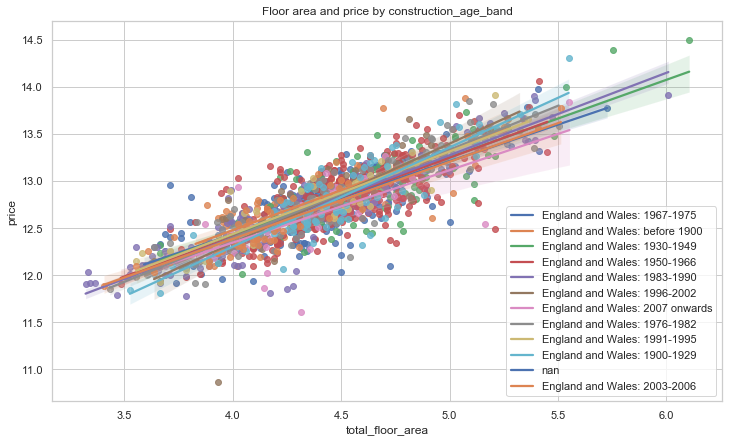

In [128]:
reg_plot('construction_age_band', ln=True)

In [129]:
data['sector'] = data['postcode'].apply(lambda x: x[:-2])
data['sector']

0       HP13 6
1       HP12 4
2       HP13 5
3       HP13 6
4       HP10 8
         ...  
1791    HP15 7
1792    HP13 7
1793    HP13 5
1794    HP12 4
1795    HP13 5
Name: sector, Length: 1796, dtype: object

In [130]:
sectors = data.groupby('sector')['persqm'].median().sort_values(ascending=False)
sectors

sector
HP10 8    5155.208333
HP10 9    4735.000000
HP10 0    4725.274725
HP15 7    4512.195122
HP11 1    4382.572828
HP15 6    4377.388316
HP13 5    4272.486772
HP12 4    4052.027027
HP13 7    4025.974026
HP12 3    3950.320513
HP13 6    3915.068167
HP11 2    3886.303543
Name: persqm, dtype: float64

In [132]:
(sectors.max() - sectors.min()) / sectors.min()

0.32650686601351653

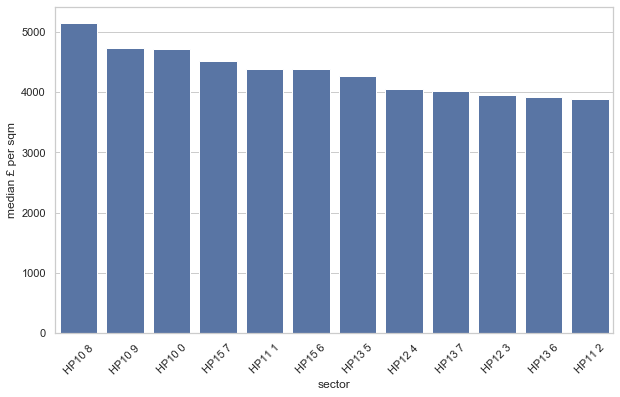

In [131]:
plt.figure(figsize=(10,6))
ax = sns.barplot(x=sectors.index, y=sectors, color='b')

plt.ylabel('median £ per sqm')
for label in ax.get_xticklabels():
    label.set_rotation(45)
plt.savefig('figures/price_by_sector.png')
plt.show()

In [57]:
data['district'] = data['sector'].apply(lambda x: x[:-2])

In [58]:
districts = data.groupby('district')['price'].median().sort_values(ascending=False)

Text(0.5, 1.0, 'Geometric mean of price by district')

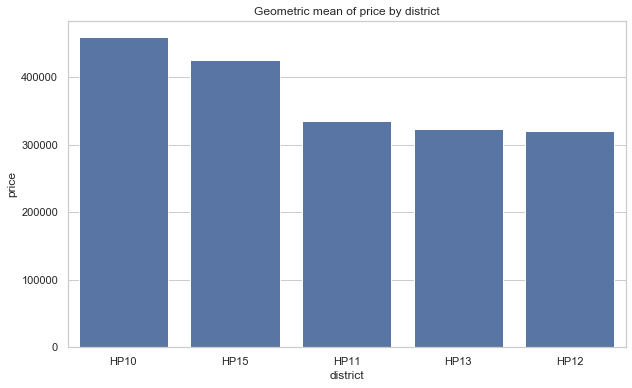

In [59]:
plt.figure(figsize=(10,6))
sns.barplot(x=districts.index, y=districts, color='b')
plt.title('Geometric mean of price by district')

In [60]:
data.drop(['district', 'sector'], axis=1, inplace=True)

In [61]:
corr_order = data.select_dtypes(include=['int64', 'float64']).corr()['price'].abs().drop('price').sort_values(ascending=False).index

In [62]:
corr_matrix = data[corr_order].corr().abs()

In [63]:
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]

In [64]:
data.drop(to_drop, axis=1, inplace=True)

In [65]:
price_correl = data.select_dtypes(include=['int64', 'float64']).corr()['price'].drop('price').sort_values(ascending=False)

In [66]:
low_corr = price_correl[price_correl.abs() < 0.2].index
data.drop(low_corr, axis=1, inplace=True)

In [67]:
final_correl = data.select_dtypes(include=['int64', 'float64']).corr()['price'].drop('price').sort_values(ascending=False)

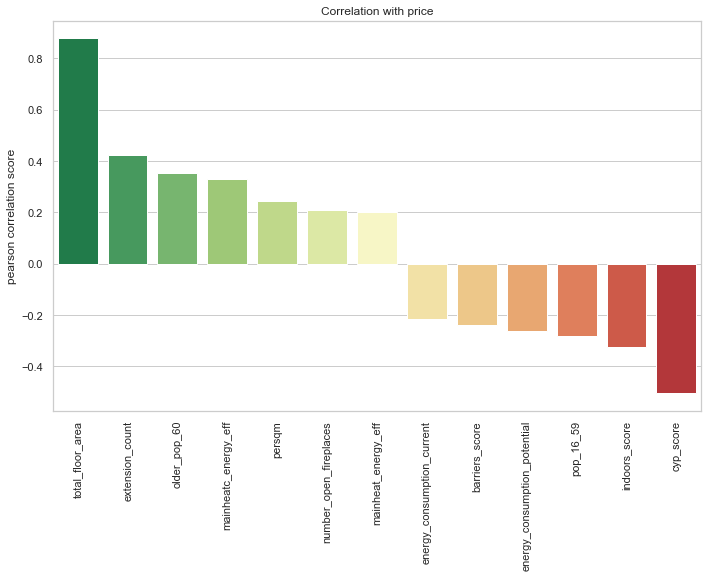

In [68]:
plt.figure(figsize=(10,8))
ax = sns.barplot(x=final_correl.index, y=final_correl, palette='RdYlGn_r')
for label in ax.get_xticklabels():
    label.set_rotation(90)
plt.tight_layout()
plt.title('Correlation with price')
plt.ylabel('pearson correlation score')
plt.savefig('figures/correlation_with_price.png')
plt.show()

In [453]:
# Fill categorical/ordinal with most common
has_nulls = data.columns[data.isnull().any()]

In [257]:
has_nulls

Index(['mains_gas_flag', 'glazed_type', 'extension_count',
       'number_open_fireplaces', 'construction_age_band'],
      dtype='object')

In [258]:
test_data = pd.read_sql('SELECT * FROM test_data;', con=engine)

In [260]:
# Replace invalid values with nan in test data
test_data.replace('', np.nan, inplace=True)
test_data.replace('N/A', np.nan, inplace=True)
test_data.replace('NO DATA!', np.nan, inplace=True)
test_data.replace('NODATA!', np.nan, inplace=True)
test_data.replace('-1', np.nan, inplace=True)
test_data.replace('INVALID!', np.nan, inplace=True)
test_data.replace('Unknown', np.nan, inplace=True)
test_data.replace('unknown', np.nan, inplace=True)
test_data.replace('not defined', np.nan, inplace=True)


In [261]:
test_data['bungalow_flag'] = np.where(test_data['property_type'] == 'Bungalow', 1, 0)

In [262]:
fill_dict = dict(zip(has_nulls, [data[x].mode()[0] for x in has_nulls]))

In [263]:
fill_dict

{'mains_gas_flag': 'Y',
 'glazed_type': 'double glazing unknown install date',
 'extension_count': 0.0,
 'number_open_fireplaces': 0.0,
 'construction_age_band': 'England and Wales: 1950-1966'}

In [264]:
data.fillna(fill_dict, inplace=True)
test_data.fillna(fill_dict, inplace=True)

In [265]:
for c in eff_cols:
    test_data[c] = test_data[c].map(eff_map)

In [267]:
data.drop('persqm', axis=1, inplace=True)

In [268]:
test_data = test_data[data.columns]
test_data.drop(test_data[test_data['total_floor_area'] <= 10].index, inplace=True)

C:\Users\neils\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [267]:
data.to_sql('train_cleaned', con=engine, index=False, if_exists='replace')

In [268]:
test_data.to_sql('test_cleaned', con=engine, index=False, if_exists='replace')

In [269]:
data['total_floor_area'].describe()

count    1796.000000
mean       91.045841
std        41.815501
min        27.720000
25%        66.000000
50%        83.000000
75%       106.250000
max       635.000000
Name: total_floor_area, dtype: float64

In [270]:
test_data['total_floor_area'].describe()

count    772.000000
mean      92.128692
std       43.461030
min        5.210000
25%       67.000000
50%       83.000000
75%      107.000000
max      438.000000
Name: total_floor_area, dtype: float64